<a href="https://colab.research.google.com/github/hyunwjang/deep/blob/main/_3_2_%EC%BC%80%EB%9D%BC%EC%8A%A4_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%97%B0%EB%B9%84_%EC%98%88%EC%B8%A1_%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras.utils import get_file, plot_model


In [ ]:
sns.set(style = 'white')
plt.style.use('seaborn-white')

### 데이터 로드

In [ ]:
dataset_path = get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/root/.keras/datasets/auto-mpg.data'

In [ ]:
columns_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower','Weight','Acceleration', 'Model year','Origin']

### 데이터 확인

In [ ]:
raw_dataset = pd.read_csv(dataset_path, names=columns_names,
                          na_values = '?', comment='\t',
                          sep = ' ', skipinitialspace= True)
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리


- 해당 데이터는 일부 데이터가 누락되어 있음

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [ ]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [ ]:
dataset['Origin'].unique()

array([1, 3, 2])

In [ ]:
origin = dataset.pop('Origin')
dataset['Use'] = (origin ==1)* 1.0
dataset['Europe'] = (origin ==2)* 1.0
dataset['Japan'] = (origin ==3)* 1.0

dataset


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Use,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [ ]:
train_dataset = dataset.sample(frac = 0.8, random_state= 0)

test_dataset = dataset.drop(train_dataset.index)

#### 데이터 조사

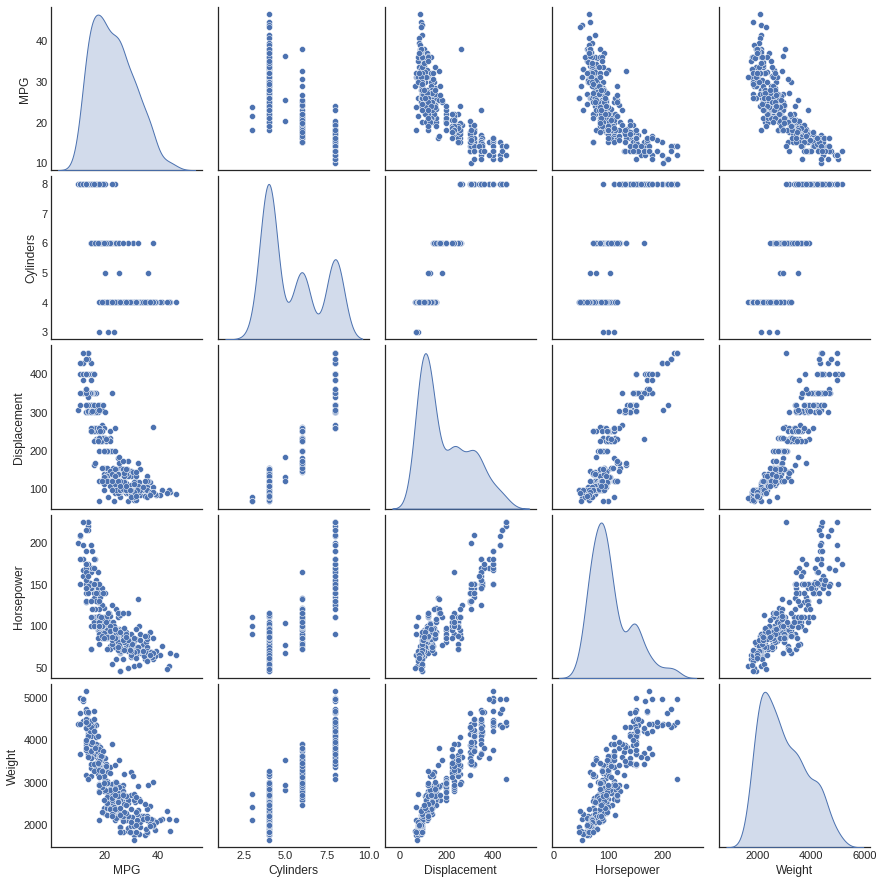

In [ ]:
sns.pairplot(train_dataset[["MPG",	'Cylinders',	'Displacement',	'Horsepower',	'Weight']],diag_kind = 'kde');

In [ ]:
train_stats = train_dataset.describe()
train_stats.pop('MPG')
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Use,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


#### 데이터의 특성과 레이블 분리

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop("MPG")

#### 데이터 정규화

In [ ]:
def normalization(x):
  return(x - train_stats['mean'])/ train_stats['std']

normed_train_data = normalization(train_dataset)
normed_test_data = normalization(test_dataset)

### 모델 구성

In [ ]:
def build_model():
  input = Input(shape=(len(train_dataset.keys())), name = 'input')
  hidden1 = Dense(64, activation = 'relu', name  = 'dense1')(input)
  hidden2 = Dense(64, activation = 'relu', name = 'dense2')(hidden1)
  output = Dense(1, name = 'output')(hidden2)

  model = Model(inputs =[input], outputs = output)

  model.compile(loss = 'mse',
                optimizer = RMSprop(0.001),
                metrics = ['mae','mse'])
  return model



In [ ]:
model = build_model()

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9)]               0         
                                                                 
 dense1 (Dense)              (None, 64)                640       
                                                                 
 dense2 (Dense)              (None, 64)                4160      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


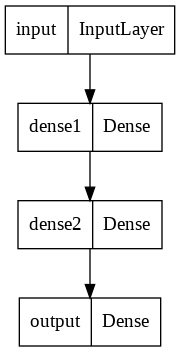

In [ ]:
plot_model(model)

### 샘플 데이터 확인

In [ ]:
sample_batch = normed_train_data[:10]
sample_result =model.predict(sample_batch)
sample_batch

1/1 [==============================] - 0s 186ms/step


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model year,Use,Europe,Japan
146,-0.869348,-1.009459,-0.784052,-1.025303,-0.379759,-0.516397,0.774676,-0.465148,-0.495225
282,-0.869348,-0.530218,-0.442811,-0.118796,0.624102,0.843910,0.774676,-0.465148,-0.495225
69,1.483887,1.482595,1.447140,1.736877,-0.738281,-1.060519,0.774676,-0.465148,-0.495225
378,-0.869348,-0.865687,-1.099044,-1.025303,-0.308055,1.660094,0.774676,-0.465148,-0.495225
331,-0.869348,-0.942365,-0.994047,-1.001603,0.875068,1.115971,-1.286751,-0.465148,2.012852
257,0.307270,0.351586,-0.390312,0.260397,0.588250,0.571849,0.774676,-0.465148,-0.495225
310,-0.869348,-1.019044,-1.177792,-1.211344,1.161885,1.115971,-1.286751,-0.465148,2.012852
328,-0.869348,-0.472709,-0.994047,0.307796,2.237451,1.115971,-1.286751,2.143005,-0.495225
125,0.307270,0.025702,-0.259066,0.132419,0.337285,-0.516397,0.774676,-0.465148,-0.495225
108,-0.869348,-0.942365,-0.442811,-0.842816,1.233589,-0.788458,-1.286751,-0.465148,2.012852


### 모델 학습

In [ ]:
epochs = 1000

historty = model.fit(normed_train_data, train_labels, epochs = epochs, validation_split = 0.2)

Epoch 1/1000
8/8 [==============================] - 1s 32ms/step - loss: 562.4308 - mae: 22.4109 - mse: 562.4308 - val_loss: 557.0311 - val_mae: 22.2104 - val_mse: 557.0311
Epoch 2/1000
8/8 [==============================] - 0s 6ms/step - loss: 515.7303 - mae: 21.3372 - mse: 515.7303 - val_loss: 509.1825 - val_mae: 21.1129 - val_mse: 509.1825
Epoch 3/1000
8/8 [==============================] - 0s 6ms/step - loss: 469.6321 - mae: 20.2579 - mse: 469.6321 - val_loss: 456.7035 - val_mae: 19.8829 - val_mse: 456.7035
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 418.6513 - mae: 19.0283 - mse: 418.6513 - val_loss: 398.8905 - val_mae: 18.4638 - val_mse: 398.8905
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 362.4993 - mae: 17.6315 - mse: 362.4993 - val_loss: 335.4499 - val_mae: 16.7821 - val_mse: 335.4499
Epoch 6/1000
8/8 [==============================] - 0s 6ms/step - loss: 303.6056 - mae: 15.9787 - mse: 303.6056 - val_loss: 272.2379 - val_

### 모델 학습 시각화

In [ ]:
historty.history.keys()

In [ ]:
hist = pd.DataFrame(historty.history)
hist['epoch'] = historty.epoch
hist

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,562.430847,22.410912,562.430847,557.031128,22.210443,557.031128,0
1,515.730347,21.337238,515.730347,509.182495,21.112932,509.182495,1
2,469.632080,20.257940,469.632080,456.703461,19.882853,456.703461,2
3,418.651337,19.028336,418.651337,398.890503,18.463831,398.890503,3
4,362.499268,17.631542,362.499268,335.449890,16.782143,335.449890,4
...,...,...,...,...,...,...,...
995,2.280558,0.890977,2.280558,8.673731,2.195646,8.673732,995
996,2.379083,0.902762,2.379083,9.076446,2.296416,9.076446,996
997,2.313577,0.892628,2.313577,9.274284,2.333409,9.274284,997
998,2.233594,0.868017,2.233594,8.842824,2.280396,8.842824,998


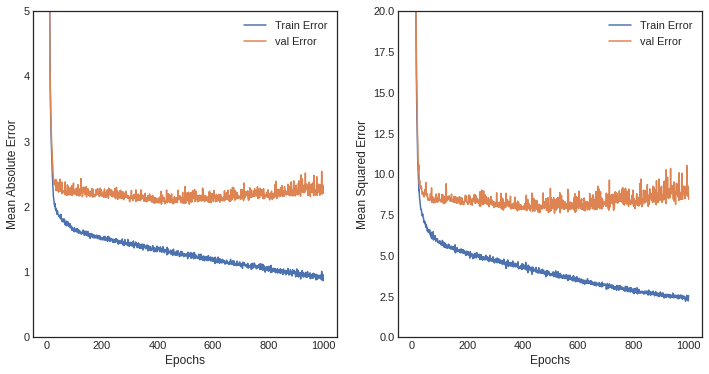

In [ ]:
def plot_hisory(historty):
  hist = pd.DataFrame(historty.history)
  hist['epoch'] = historty.epoch
  plt.figure(figsize = (12,6))

  plt.subplot(1,2,1)
  plt.xlabel('Epochs')
  plt.ylabel('Mean Absolute Error')
  plt.plot(hist['epoch'],hist['mae'], label = 'Train Error')
  plt.plot(hist['epoch'],hist['val_mae'], label = 'val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.subplot(1,2,2)
  plt.xlabel('Epochs')
  plt.ylabel('Mean Squared Error')
  plt.plot(hist['epoch'],hist['mse'], label = 'Train Error')
  plt.plot(hist['epoch'],hist['val_mse'], label = 'val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.show()

plot_hisory(historty)
  

### EarlyStopping을 이용한 규제화

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:
model =  build_model()

early_stop = EarlyStopping(monitor = 'val_loss', patience = 10)

history = model.fit(normed_train_data, train_labels, epochs = epochs, validation_split  = 0.2, callbacks = [early_stop])

Epoch 1/1000
8/8 [==============================] - 1s 25ms/step - loss: 553.6335 - mae: 22.2841 - mse: 553.6335 - val_loss: 541.8690 - val_mae: 22.0015 - val_mse: 541.8690
Epoch 2/1000
8/8 [==============================] - 0s 5ms/step - loss: 499.2164 - mae: 21.0714 - mse: 499.2164 - val_loss: 481.3058 - val_mae: 20.6551 - val_mse: 481.3058
Epoch 3/1000
8/8 [==============================] - 0s 5ms/step - loss: 440.8360 - mae: 19.7288 - mse: 440.8360 - val_loss: 414.2405 - val_mae: 19.0595 - val_mse: 414.2405
Epoch 4/1000
8/8 [==============================] - 0s 6ms/step - loss: 377.2448 - mae: 18.1611 - mse: 377.2448 - val_loss: 342.2883 - val_mae: 17.2002 - val_mse: 342.2883
Epoch 5/1000
8/8 [==============================] - 0s 5ms/step - loss: 311.3768 - mae: 16.3736 - mse: 311.3768 - val_loss: 272.0869 - val_mae: 15.1497 - val_mse: 272.0869
Epoch 6/1000
8/8 [==============================] - 0s 5ms/step - loss: 246.3215 - mae: 14.3853 - mse: 246.3215 - val_loss: 204.3595 - val_

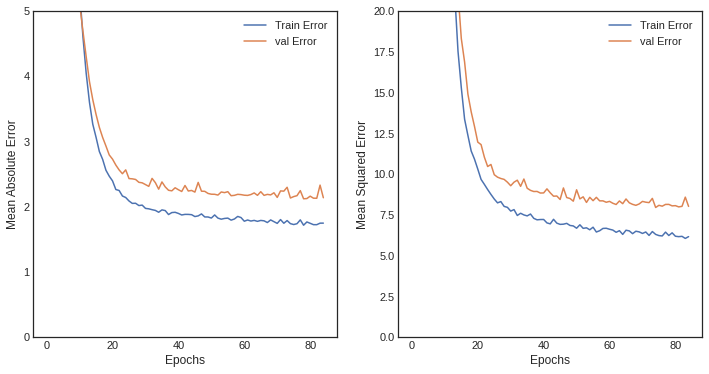

In [ ]:
plot_hisory(history)

### 모델 평가

In [ ]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose = 2)

print(mae)

3/3 - 0s - loss: 5.6328 - mae: 1.9180 - mse: 5.6328 - 22ms/epoch - 7ms/step
1.9179925918579102


### 학습된 모델을 통한 예측

3/3 [==============================] - 0s 6ms/step


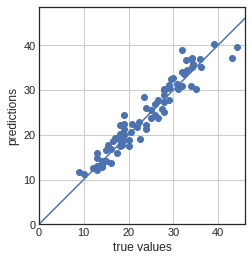

In [ ]:
test_pred = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_pred)
plt.xlabel('true values')
plt.ylabel('predictions')
plt.axis('equal')
plt.axis('square')

plt.grid()
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
plt.plot([-100,100],[-100,100]);


Text(0, 0.5, 'count')

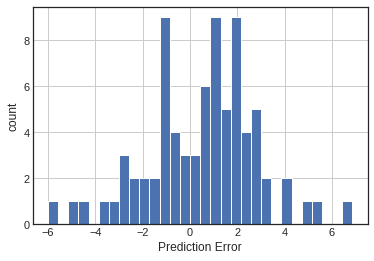

In [ ]:
error = test_pred - test_labels

plt.hist(error, bins = 30)
plt.xlabel('Prediction Error')
plt.grid()
plt.ylabel('count')